In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from pathlib import Path
import requests

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661]]) tensor([3, 2, 2])


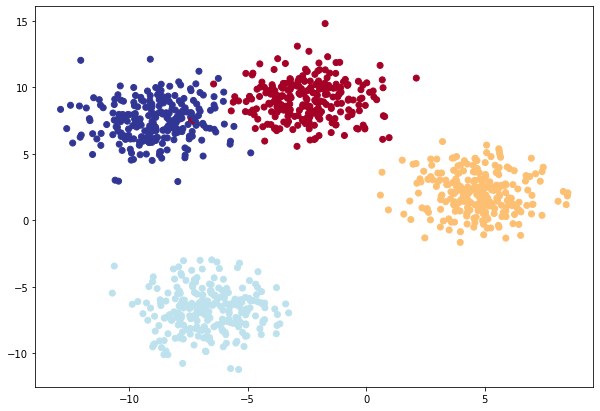

In [ ]:
# Create dataset of blobs on an xy coordinate grid
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,  # X feature
                            centers=NUM_CLASSES,    # y labels
                            cluster_std=1.5,  # give the culters a little "shake up"
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).to(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)  # Because it's multi-class, the function that we're going to use is gonna require a dtype of long  (basically an int)
print(X_blob[:3], y_blob[:3])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);  # (x, y, color, cmap)


# basically, X_blob contains the (x, y) data
# y_blob contains the color/class of that point

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build the model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    # input_features = number of features in the dataset
    # output_features = number of classes
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
model = BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
# Does our output actually match the way our y_blob_train is structured?
model(X_blob_train.to(device))[:5]

tensor([[ 0.3590,  0.3490, -0.0839,  0.2119],
        [-0.6285,  0.0414,  0.3433,  1.5350],
        [-0.8187,  0.5564, -1.0121, -0.4831],
        [-0.7429,  0.3740, -0.5988, -0.0875],
        [-0.6429,  0.0884,  0.3837,  1.4620]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# Use softmax activation function to get prediction labels with multi-class classification problems
# softmax function calculates the probability of each prediction class being the actual preidcted class compared to all other possible classes


# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
# softmax will return a list of the same dimension with the probabilities of each class (summing up the probabilities will equal 1)
# So use `.argmax()` alongside softmax and you get the MOST likely class

In [ ]:
# Training loop
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_blob_train)  # no need to squeeze since argmax is gonna take care of that for us
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ###Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch 0 | Loss: 1.54774, Acc: 40.50% | Test Loss: 1.12560, Test Acc: 41.00%
Epoch 10 | Loss: 0.46277, Acc: 96.12% | Test Loss: 0.39110, Test Acc: 98.50%
Epoch 20 | Loss: 0.19840, Acc: 99.00% | Test Loss: 0.16312, Test Acc: 99.50%
Epoch 30 | Loss: 0.10114, Acc: 99.00% | Test Loss: 0.08506, Test Acc: 99.50%
Epoch 40 | Loss: 0.06985, Acc: 99.12% | Test Loss: 0.05771, Test Acc: 99.50%
Epoch 50 | Loss: 0.05543, Acc: 99.25% | Test Loss: 0.04467, Test Acc: 99.50%
Epoch 60 | Loss: 0.04743, Acc: 99.12% | Test Loss: 0.03731, Test Acc: 99.50%
Epoch 70 | Loss: 0.04245, Acc: 99.12% | Test Loss: 0.03239, Test Acc: 99.50%
Epoch 80 | Loss: 0.03912, Acc: 99.12% | Test Loss: 0.02915, Test Acc: 99.50%
Epoch 90 | Loss: 0.03676, Acc: 99.12% | Test Loss: 0.02683, Test Acc: 99.50%


In [ ]:
# Making Predictions
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)

  # Turn logits into prediction probabilities
  y_probs = torch.softmax(y_logits, dim=1)

  # Turn pred probabilities into prediction labels
  y_labels = y_probs.argmax(dim=1)

In [ ]:
# Make predictions (using `plot_decision_boundary()`, which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes)
if Path("helper_function.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

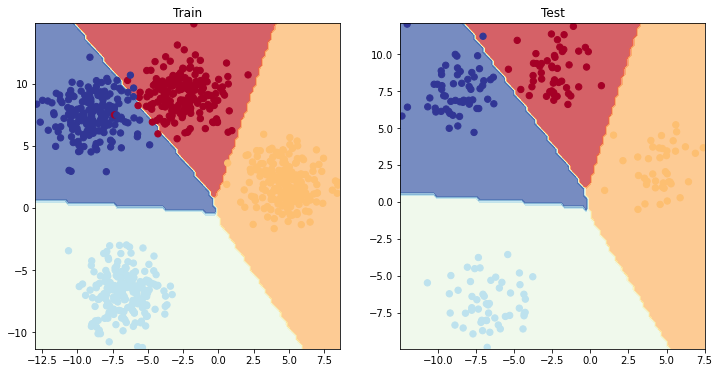

In [ ]:
# Visualize our data/plot our data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)